# Generative Adversarial Networks

Attempt of building a GAN network for the MNIST dataset.

Most of the code is inspired by:
- https://www.youtube.com/watch?v=xjdMgerRxWs (with some adjustments)
- https://www.amazon.co.uk/Deep-Learning-TensorFlow-Keras-Regression/dp/1838823417/ref=sr_1_2?dchild=1&keywords=tensorflow&qid=1598617726&sr=8-2

In [1]:
import math
import numpy as np

In [2]:
from matplotlib import pyplot as plt

In [3]:
import torch
from torch import nn
from torch import optim

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
BATCH_SIZE = 64

In [6]:
transforms = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./NewData', download=True, train=True, transform = transforms)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size = BATCH_SIZE)

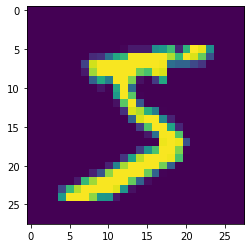

In [7]:
plt.imshow(trainset.data[0].numpy())

In [8]:
# ?torchvision.utils.make_grid

In [9]:
IMAGES = 8*8

# select 64 samples
def plot_grid(_images):
    im = torchvision.utils.make_grid(_images)
    imnp = im.numpy()
    imnp = np.transpose(imnp, (1, 2, 0))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(imnp)
    plt.xticks([])
    plt.yticks([])
    plt.show()

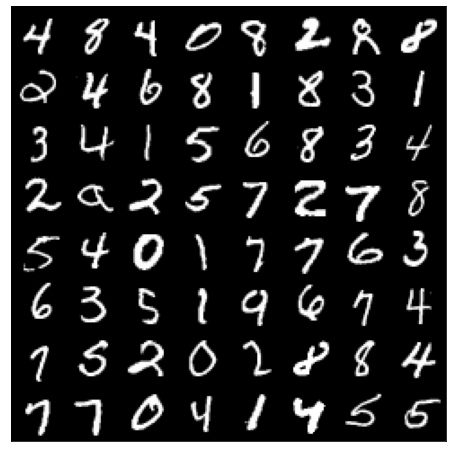

In [10]:
indexes = np.random.randint(0, trainset.data.shape[0], IMAGES)
images = trainset.data[indexes].unsqueeze(1)

# print(images.size())

plot_grid(images)

# Network

In [11]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [12]:
class Generator(nn.Module):
    def __init__(self, Z_dim, h_dim, X_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        self.model.apply(init_weight)
    
    def forward(self, input):
        return self.model(input)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, h_dim, X_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.model.apply(init_weight)
        
    def forward(self, input):
        return self.model(input)

In [14]:
Z_DIM = 100
H_DIM = 128
X_DIM = 28 * 28

In [15]:
LR = 1e-3

In [16]:
G = Generator(Z_DIM, H_DIM, X_DIM)
D = Discriminator(H_DIM, X_DIM)

In [17]:
g_optim = optim.Adam(G.parameters(), lr = LR)
d_optim = optim.Adam(D.parameters(), lr = LR)

In [18]:
d_loss_fn = nn.BCELoss()
g_loss_fn = nn.BCELoss()

Epoch: 0, G_loss: 5.150158, D_loss: 0.012841


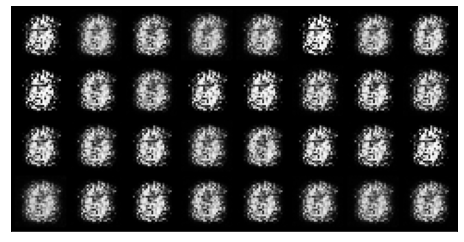

Epoch: 1, G_loss: 3.497340, D_loss: 0.053543


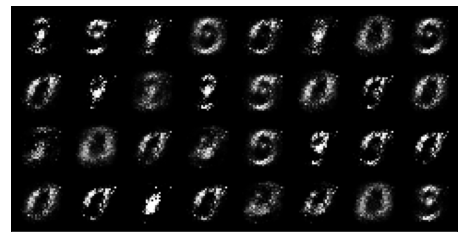

Epoch: 2, G_loss: 3.908784, D_loss: 0.071422


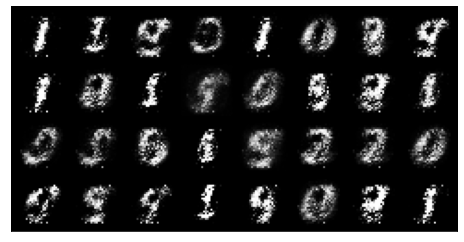

Epoch: 3, G_loss: 4.384686, D_loss: 0.068391


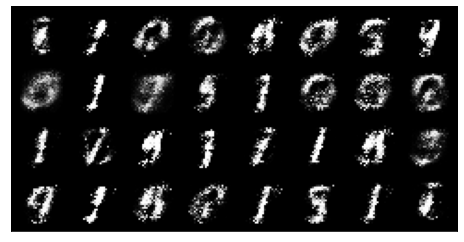

Epoch: 4, G_loss: 3.942139, D_loss: 0.098520


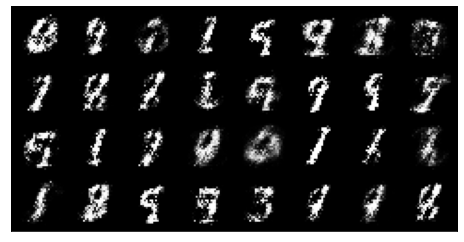

Epoch: 5, G_loss: 3.716811, D_loss: 0.253247


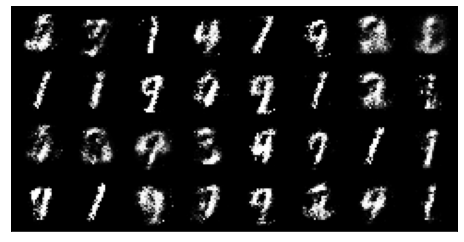

Epoch: 6, G_loss: 3.141051, D_loss: 0.194659


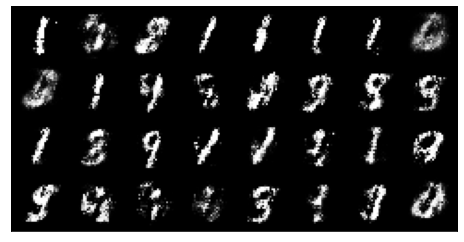

Epoch: 7, G_loss: 3.049947, D_loss: 0.263777


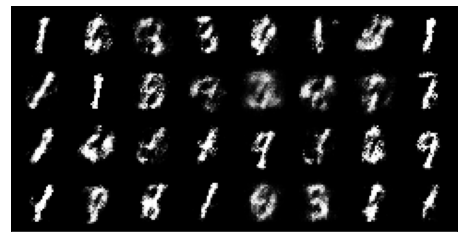

Epoch: 8, G_loss: 2.244575, D_loss: 0.302977


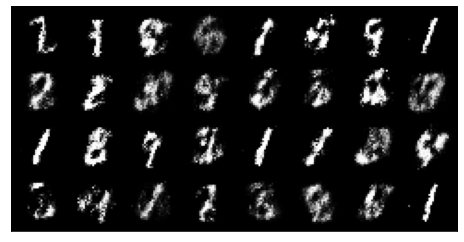

Epoch: 9, G_loss: 2.482545, D_loss: 0.336169


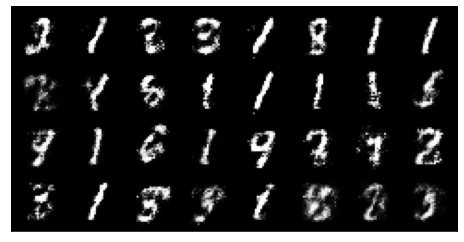

In [19]:
for epoch in range(10):
    g_loss_run = None
    d_loss_run = None
    for i, data in enumerate(trainloader):
        X, y = data
        # reshape to (BATCH_SIZE, h*w)
        X = X.view(X.size(0), -1)
        
#         print('X', X.size())
#         print('y', y.size())
        
        batch_size = X.shape[0]
    
        ones = torch.ones(batch_size, 1)
        zeros = torch.zeros(batch_size, 1)
        g_input = torch.randn(batch_size, Z_DIM)
        
#         print('ones', ones.size())
#         print('zeros', zeros.size())
#         print('g_input', g_input.size())
        
        g_output = G(g_input)
#         print('g_output', g_output.size())
        
        d_output_real = D(X)
        d_output_fake = D(g_output)
        
#         print('d_output_real', d_output_real.size())
#         print('d_output_fake', d_output_fake.size())
        
        d_output_pred = torch.cat((d_output_real, d_output_fake), 0)
        d_output_exp = torch.cat((ones, zeros), 0)
    
        d_loss = d_loss_fn(d_output_pred, d_output_exp)
        if d_loss_run is None:
            d_loss_run = d_loss
        else:
            d_loss_run = (d_loss_run + d_loss) / 2.

        d_optim.zero_grad()        
        d_loss.backward()
        d_optim.step()
        
#         print(d_loss_real, d_loss_fake, d_loss)
        
        g_input = torch.randn(batch_size, Z_DIM)
        g_output = G(g_input)
        d_output_fake = D(g_output)
        
        g_loss = g_loss_fn(d_output_fake, ones) # <-- pushing the fake ones towards ones
        if g_loss_run is None:
            g_loss_run = g_loss
        else:
            g_loss_run = (g_loss_run + g_loss) / 2.
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
    
    print(f'Epoch: {epoch}, G_loss: {g_loss_run:.6f}, D_loss: {d_loss_run:.6f}')
    
    g_input = torch.randn(batch_size, Z_DIM)
    g_output = G(g_input).detach()
    g_output = g_output.view(batch_size, 1, 28, 28)
    
    plot_grid(g_output)